In [1]:
!pip install -qU pypdf
!pip install -qU pypdf scikit-learn langchain_community
!pip install --quiet langchain langchain-text-splitters langchain_google_genai
!pip install --quiet langchain_chroma
!pip install --quiet cohere
!pip install --upgrade --quiet langchain
!pip install --quiet PyPDF2

!pip install -q cohere


!pip install --quiet google-api-python-client google-auth-httplib2 google-auth-oauthlib PyPDF2 langgraph


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.0/298.0 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 26.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 42.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 409.5/409.5 kB 24.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.3/41.3 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 3.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 628.3/628.3 kB 16.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 48.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.8/94.8 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.6/278.6 kB 18.0 MB/s eta 0:00:

In [2]:
from google.colab import userdata
from langchain_core.prompts import ChatPromptTemplate
import os
import google.generativeai as genai
from langchain_google_genai import GoogleGenerativeAI
import sqlite3
from google.colab import files
import PyPDF2
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_chroma import Chroma
from langchain.embeddings import CohereEmbeddings
from langchain.schema import Document
from uuid import uuid4
from langgraph.store.memory import InMemoryStore
from langchain.schema import Document
from pprint import pprint
from typing import Any, List, TypedDict
from IPython.display import display, Markdown
from langchain_core.runnables.config import RunnableConfig
from langgraph.store.base import BaseStore


In [3]:


GEMINI_API_KEY = userdata.get("GEMINI_API_KEY")

genai.configure(api_key=GEMINI_API_KEY)

llm = GoogleGenerativeAI(google_api_key=GEMINI_API_KEY, model="gemini-1.5-flash")

In [4]:
import sqlite3
from uuid import uuid4
from langchain.schema import Document
from langchain.embeddings import CohereEmbeddings
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.vectorstores import Chroma
from IPython.display import Markdown
from langchain_core.runnables.config import RunnableConfig
from langgraph.store.base import BaseStore
from langgraph.store.memory import InMemoryStore
from typing import List, Any, TypedDict
from pprint import pprint
from langgraph.graph import StateGraph, END,START
from IPython.display import Image, display
from langgraph.prebuilt import tools_condition
from typing import Literal

import PyPDF2
from google.colab import files

# SQLite database setup
db_path = "uploaded_files_metadata.db"

# Function to initialize the database and create table if not exists
def initialize_db():
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()
    cursor.execute('''
        CREATE TABLE IF NOT EXISTS uploaded_files (
            id INTEGER PRIMARY KEY AUTOINCREMENT,
            collection_name TEXT UNIQUE,
            file_name TEXT
        )
    ''')
    conn.commit()
    conn.close()

# Function to insert file metadata into SQLite
def save_metadata(collection_name, file_name):
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()
    cursor.execute('''
        INSERT OR IGNORE INTO uploaded_files (collection_name, file_name)
        VALUES (?, ?)
    ''', (collection_name, file_name))
    conn.commit()
    conn.close()

# Function to load metadata from SQLite
def load_metadata():
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()
    cursor.execute('SELECT collection_name, file_name FROM uploaded_files')
    rows = cursor.fetchall()
    conn.close()

    return {row[0]: row[1] for row in rows}

# Load and split PDF content
def load_pdf(file_path):
    try:
        with open(file_path, 'rb') as file:
            reader = PyPDF2.PdfReader(file)
            text = ""
            for page in reader.pages:
                text += page.extract_text() + "\n"
            return text.strip()
    except Exception as e:
        print(f"Error loading PDF: {e}")
        return None

# Process PDF to update vector store
def process_pdf(file_name, collection_name):
    pdf_content = load_pdf(file_name)
    if pdf_content:
        print("PDF content loaded successfully.")

        cohere_api_key = userdata.get("Embedding_API")  # Replace with actual key
        embedding_function = CohereEmbeddings(
            model="embed-english-light-v2.0",
            cohere_api_key=cohere_api_key,
            user_agent="LangChainCohere"
        )


        vector_db = Chroma(
            collection_name=collection_name,
            embedding_function=embedding_function
        )

        text_splitter = RecursiveCharacterTextSplitter(chunk_size=7500, chunk_overlap=100)
        docs = [Document(page_content=pdf_content)]
        chunks = text_splitter.split_documents(docs)

        vector_db.add_texts([chunk.page_content for chunk in chunks])

        print(f"PDF data from {file_name} updated in vector_db.")
        save_metadata(collection_name, file_name)

# Handle file selection or upload
def handle_file_selection() -> str:
    uploaded_files_metadata = load_metadata()
    if uploaded_files_metadata:
        print("Previously uploaded files:")
        for i, (collection, file_name) in enumerate(uploaded_files_metadata.items()):
            print(f"{i + 1}: {file_name} (Collection: {collection})")
        choice = input("Enter the number of the file to use or 'N' to upload a new one: ")

        if choice.upper() == 'N':
            uploaded = files.upload()
            if uploaded:
                uploaded_file_path = next(iter(uploaded))
                print(f"Uploaded file: {uploaded_file_path}")

                unique_collection_name = f"pdf_chunks_{uuid4()}"
                process_pdf(uploaded_file_path, unique_collection_name)
                return unique_collection_name
        else:
            chosen_index = int(choice) - 1
            chosen_collection = list(uploaded_files_metadata.keys())[chosen_index]
            print(f"Using previously uploaded file: {uploaded_files_metadata[chosen_collection]}")
            return chosen_collection
    else:
        print("No files found in the vector DB. Please upload a new file.")
        uploaded = files.upload()
        if uploaded:
            uploaded_file_path = next(iter(uploaded))
            print(f"Uploaded file: {uploaded_file_path}")

            unique_collection_name = f"pdf_chunks_{uuid4()}"
            process_pdf(uploaded_file_path, unique_collection_name)
            return unique_collection_name

# Initialize the database
initialize_db()

# Get the collection name based on user input
collection_name = handle_file_selection()

No files found in the vector DB. Please upload a new file.


Saving python-basics-sample-chapters (2).pdf to python-basics-sample-chapters (2).pdf
Uploaded file: python-basics-sample-chapters (2).pdf
PDF content loaded successfully.


<ipython-input-4-812755e16139>:79: LangChainDeprecationWarning: The class `CohereEmbeddings` was deprecated in LangChain 0.0.30 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-cohere package and should be used instead. To use it run `pip install -U :class:`~langchain-cohere` and import as `from :class:`~langchain_cohere import CohereEmbeddings``.
  embedding_function = CohereEmbeddings(
<ipython-input-4-812755e16139>:86: LangChainDeprecationWarning: The class `Chroma` was deprecated in LangChain 0.2.9 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-chroma package and should be used instead. To use it run `pip install -U :class:`~langchain-chroma` and import as `from :class:`~langchain_chroma import Chroma``.
  vector_db = Chroma(


PDF data from python-basics-sample-chapters (2).pdf updated in vector_db.


In [5]:
from langchain.schema import Document
from pprint import pprint
from typing_extensions import Any, List, TypedDict
from IPython.display import display, Markdown
from langchain_core.runnables.config import RunnableConfig
from langgraph.checkpoint.memory import MemorySaver
import json
from langgraph.store.base import BaseStore

class Question(TypedDict):
    question: str
    options: dict[str, str]
    answer: str
    user_response: str

class StateDocument(TypedDict):
    questions: List[Question]
    total_questions: int
    current_question: int
    human_input: str
    ai_output: str
    human_input_2: str
    chat: str
    decision: str
    score: int
    reason : str


from IPython.display import Markdown
from langgraph.store.memory import InMemoryStore

config = {"configurable": {"user_id": "1"}}
across_thread_memory = InMemoryStore()


# Define a VectorDatabase class to interact with the Chroma database
class VectorDatabase:
    def __init__(self, chroma_db: Chroma):
        self.chroma_db = chroma_db

    def similarity_search(self, query: str, k: int) -> List[Any]:
        """Performs a similarity search using the Chroma database."""
        return self.chroma_db.similarity_search(query, k=k)

def questions(state: StateDocument) -> StateDocument:
    while True:

      total_questions = __builtins__.input("How many questions do you want to generate (0 to 25): ")
      try:
        total_questions = int(total_questions)  # Convert to integer
        if 0 < total_questions <= 25:
          state["human_input"] = total_questions
          break  # Exit the loop if input is valid
        else:
          print("Invalid input. Please enter a number between 1 and 25.")
      except ValueError:
        print("Invalid input. Please enter a valid number.")
        return state





def clean_json_input(raw_input):
    """
    Cleans the raw JSON input by removing enclosing backticks and the word 'json'.

    Args:
        raw_input (str): The raw JSON string with backticks and 'json'.

    Returns:
        dict: A Python dictionary representation of the cleaned JSON.
    """
    try:
        # Remove backticks and 'json' keyword
        cleaned_input = raw_input.strip("```").replace("json", "").strip()
        cleaned_input = cleaned_input.replace("```", "")
        # print(cleaned_input)
        # Parse the cleaned JSON string into a dictionary
        return json.loads(cleaned_input)

    except json.JSONDecodeError as e:
        return {"error": f"Invalid JSON format: {e}"}

    # Clean the input and print the result
    cleaned_json = clean_json_input(raw_input)
    return json.dumps(cleaned_json, indent=4)


def parse_questions(ai_output):
    """
    Parses multiple questions, options, answers, and user responses from AI output and stores them.

    Args:
        ai_output: The output from the language model, expected to be in JSON format as a list of questions.

    Returns:
        A list of dictionaries representing the questions in the desired format.
    """
    try:
        # Parse the AI output into a Python object
        if isinstance(ai_output, list):
            # print("Ai out put is list")
            parsed_output = ai_output
        else:
            # print("Ai out put is Json")
            parsed_output = json.loads(ai_output)

        # # Validate the structure
        if not isinstance(parsed_output, list):
            raise ValueError("AI output must be a list of questions.")


        # Process each question and store it
        questions = []
        for question_data in parsed_output:
            question = question_data.get("question")
            options = question_data.get("options")
            answer = question_data.get("answer")

            # Validate required fields
            if not question or not options or not answer:
                raise ValueError("Each question must include 'question', 'options', and 'answer'.")

            if not isinstance(options, dict):
                raise ValueError("Options must be a dictionary with keys (A, B, C, D).")
            structured_options = [
              f"{key}: {value}" for key, value in options.items()]

            # Add the question to the list
            questions.append({
                "question": question,
                "options": structured_options,
                "answer": answer,
                "user_response": None  # Default value
            })

        return questions

    except json.JSONDecodeError:
        print("Error: AI output is not valid JSON.")
    except ValueError as e:
        print(f"Error: {e}")
    except Exception as e:
        print(f"Unexpected error: {e}")

    return None


def node_2(db: VectorDatabase, state: StateDocument) -> StateDocument:

    no_of_questions = state["human_input"]
    state["total_questions"] = int(no_of_questions)
    # Format the prompt for quiz creation
    prompt = f"""
    You are an expert quiz creator. Create {no_of_questions} quiz questions. Each question should have four multiple-choice options (A, B, C, D), and provide the correct answer.

    Strictly adhere to the following format for each question:
    [
        {{
            'question': '[Question Text]',
            'options': {{
                'A': '[Option A]',
                'B': '[Option B]',
                'C': '[Option C]',
                'D': '[Option D]'
            }},
            'answer': '[Correct Option Letter]'  # Only use A, B, C, or D
        }},
        ...
    ]

    For example:
    [
        {{
            'question': 'What is the capital of France?',
            'options': {{
                'A': 'Berlin',
                'B': 'Madrid',
                'C': 'Paris',
                'D': 'Rome'
            }},
            'answer': 'C'
        }}
    ]

    Do not deviate from this format. Do not hallucinate. Provide all questions in this exact structure.
    """

    # Retrieve context from the database
    relevant_docs = db.chroma_db.get()
    documents = [Document(page_content=text) for text in relevant_docs["documents"]]
    context = " ".join([doc.page_content for doc in documents])

    prompt_with_context = f"{prompt}\n\nContext: {context}"

    # Call your LLM here (replace with actual LLM call)
    result = llm.invoke(prompt_with_context)
    state["questionset"] = result
    clean = clean_json_input(result)
    parsed = parse_questions(clean)
    state["questions"] = parsed
    # print(parsed)
    # return state

def node_3(db: VectorDatabase, state: StateDocument, config: RunnableConfig, store: BaseStore) -> StateDocument:
    # Retrieve context related to recent PDF for chat input
    user_id = config["configurable"]["user_id"]
    namespace = (user_id)
    existing_memory = store.get(namespace, "user_memory")

    if existing_memory:
        existing_memory_content = existing_memory.value.get('memory')
    else:
        existing_memory_content = "No existing memory found."


    # Check if existing_memory is a dictionary and has a 'memory' key.
    # If not, assume it's the memory content and use it directly.


    relevant_docs = db.similarity_search(state["human_input_2"], k=2)
    context = " ".join([doc.page_content for doc in relevant_docs])

    # Construct the prompt with context
    prompt = f"""
    Provide information based on the context below.
    Don't hallucinate or web search information.
    If user greet you then interact with him greet him/her.
    But when user ask any question then provide him with answer.
    or prompt similar to it just to help out user.
    Query input: "{state['human_input_2']}"
    Context: {context}

    You are a helpful assistant with memory that provides information about the user.
    If you have memory for this user, use it to personalize your responses.
    Here is the memory (it may be empty): {existing_memory_content}
    User: {state["human_input_2"]}"""

    # Invoke the LLM with the prompt, no need to format again
    state["chat"] = llm.invoke(prompt)
    store.put(namespace, "user_memory", {"memory": state["chat"]})  # Use send_message and extract the text from the response
    return state



cohere_api_key = userdata.get("Embedding_API")  # Replace with actual key
embedding_function = CohereEmbeddings(
    model="embed-english-light-v2.0",
    cohere_api_key=cohere_api_key,
    user_agent="LangChainCohere"
)

def display_quiz(state: StateDocument) -> StateDocument:
    """
    Conducts a quiz by asking questions to the user and scoring their answers.

    Args:
        state (STATE): The current state containing questions, scores, and progress.

    Returns:
        STATE: The updated state after the quiz has been completed.
    """
    state['current_question'] = 0
    # Loop through all questions
    while state['current_question'] < state['total_questions']:
        # Get the current question data
        question_data = state['questions'][state['current_question']]
        question_text = question_data["question"]
        options = question_data["options"]  # Get options for the current question

        # Present the question and options to the user
        print(f"\n\nQuestion {state['current_question'] + 1}: {question_text}\n")
        for option in options:
            print(option)
        # Instruct the user on how to answer
        display(Markdown("\nPlease answer with A, B, C, or D."))

        # Get and validate user input
        while True:
            user_answer = __builtins__.input("Your answer: ").strip().lower()  # Get user input and strip whitespace
            if user_answer in ['a', 'b', 'c', 'd']:
                break  # Valid answer; exit the loop
            else:
               display(Markdown("\nInvalid answer. Please answer with A, B, C, or D."))

        # Check the answer and update score
        if user_answer.upper() == question_data["answer"]:  # Compare with the correct answer in uppercase
            score = 1  # Award 1 point for a correct answer
            # print("Correct!\n\n Explanation: ", question_data["explanation"])
            display(Markdown("Correct!"))
        else:
            score = 0
            # print("Incorrect. The correct answer was:", question_data["answer"], "\n\n Explanation: ", question_data["explanation"])
            display(Markdown(f"Incorrect. The correct answer was: {question_data['answer']}"))


        # Update the question's score and the overall total score
        question_data["score"] = score  # Store score in the question data
        state['score'] += score  # Update total score
        state['current_question'] += 1  # Move to the next question


    display(Markdown(f"Quiz finished! Your total score is: {state['score']}/{state['total_questions']}"))
    return state



state: StateDocument = {"human_input": "", "human_input_2": "", "decision": "", "chat": "", "ai_output": "", "score": 0,"reason":""}

if collection_name:

    vector_db = VectorDatabase(Chroma(collection_name=collection_name, embedding_function=embedding_function))



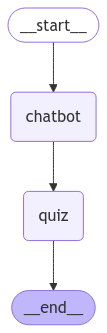

In [6]:
workflow = StateGraph(StateDocument)

def quiz1(state:StateDocument):
  questions(state)
  node_2(vector_db, state)
  display_quiz(state)
  return state


def chatbot(state: StateDocument):
  while True:
      state["human_input_2"] = __builtins__.input("What do you want to know about? (type 'quit' to exit chat): ").strip()
      if state["human_input_2"].lower() == "quit":
        print("Exiting chat mode.")
        break
        # Pass config and across_thread_memory to node_3
      node_3(vector_db, state, config, across_thread_memory)
      display(Markdown(f"Chat response: {state['chat']}"))
  return state


workflow.add_node("quiz",quiz1)
workflow.add_node("chatbot",chatbot)


workflow.add_edge(START,"chatbot")
workflow.add_edge("chatbot","quiz")
workflow.add_edge("quiz",END)


graph = workflow.compile()

display(Image(graph.get_graph().draw_mermaid_png()))



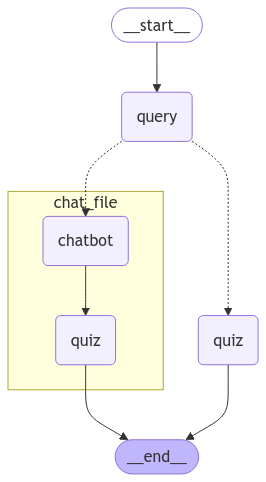

In [7]:


def get_user_input(state:StateDocument):
   query_input = __builtins__.input("Type 'chat' to chat or 'quiz' to start the quiz: ").lower().strip()
   state["decision"] = query_input
   return state

def chatfile(state:StateDocument):
    if state["decision"] == "chat":
        chatbot(vector_db, state)
    return state


def quiz(state:StateDocument):
    if state["decision"] == "quiz":
        questions(state)
        node_2(vector_db, state)
        display_quiz(state)
    return state



def node_0(state: StateDocument) -> Literal["chat_file","quiz"]:

    if state["decision"] == "chat":
        return "chat_file"
    else:
      return "quiz"




builder = StateGraph(StateDocument)
builder.add_node("quiz",quiz)
builder.add_node("chat_file",workflow.compile())


builder.add_node("query",get_user_input)




builder.add_edge(START,"query")
builder.add_conditional_edges("query",node_0)
builder.add_edge("quiz",END)
builder.add_edge("chat_file",END)






app = builder.compile()

display(Image(app.get_graph(xray=1).draw_mermaid_png()))

In [8]:
graph = app.invoke(state)

Type 'chat' to chat or 'quiz' to start the quiz: chat
What do you want to know about? (type 'quit' to exit chat): hi im muzzamil tell me about this file


Chat response: Hi Muzzamil!  This file appears to be a book excerpt about learning Python programming.  It covers topics such as setting up Python, handling errors (syntax and runtime), using variables, and includes exercises and challenges to help you learn by doing.  The book also offers bonus resources and online quizzes to aid your learning.  Is there anything specific you'd like to know about the file's contents?


What do you want to know about? (type 'quit' to exit chat): quit
Exiting chat mode.
How many questions do you want to generate (0 to 25): 2


Question 1: What is the result of the following Python code snippet? 
python
string1 = "abra"
string2 = "cadabra"
magic_string = string1 + string2
print(magic_string)


A: abra cadabra
B: abracadabra
C: Error: Cannot concatenate strings
D: 2



Please answer with A, B, C, or D.

Your answer: s



Invalid answer. Please answer with A, B, C, or D.

Your answer: a


Incorrect. The correct answer was: B



Question 2: What will be printed to the console after executing this Python code? 
python
my_string = "Hello, World!"
print(my_string.upper().startswith("H"))


A: HELLO, WORLD!
B: True
C: False
D: Error: 'str' object has no attribute 'startswith'



Please answer with A, B, C, or D.

Your answer: b


Incorrect. The correct answer was: C

Quiz finished! Your total score is: 0/2